<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Simple-Bandit-algorithms" data-toc-modified-id="Simple-Bandit-algorithms-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Simple Bandit algorithms</a></span></li></ul></div>

In [11]:
%load_ext autoreload
%autoreload 2

# add modules from parent package
import sys
sys.path.append('..')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

## Simple Bandit algorithms

bernoulli bandit is used below

In [210]:
import itertools

from joblib import Parallel, delayed

from bandits.bandits import BernoulliBanditEnv
from bandits.agents import EpsilonGreedyAgent, UCB1Agent, ThompsonSamplingBetaAgent

In [226]:
np.random.seed(2)
N_SIMULATIONS = 50
T = 10000
K = 5

eps = 1e-2# probability of exploration
alpha = 1

In [227]:
def simulate_agent(T, K, agent_tuple, rng_seed=1):
    np.random.seed(rng_seed)
    probs = np.random.uniform(0, 1, size=K)
    env = BernoulliBanditEnv(probs=probs)
    
    name, agent_func = agent_tuple
    agent = agent_func(env)
    observation = env.reset()  # initial observation
    reward_history = []
    for _ in range(T):
        action = agent.get_action(observation)
        observation, reward, done, info = env.step(action)
        reward_history.append(reward)
        agent.update_estimates(action, observation, reward)
    env.close()
    
    regret = np.cumsum(np.max(env.max_reward) - reward_history)
    return rng_seed, name, regret

In [228]:
agent_funcs = [
    (f"EpsilonGreedy {eps=}", lambda env: EpsilonGreedyAgent(eps=eps, num_arms=env.action_space.n)),
    ("UCB1", lambda env: UCB1Agent(alpha=alpha, num_arms=env.action_space.n)),
    ("ThompsonSampling", lambda env: ThompsonSamplingBetaAgent(num_arms=env.action_space.n)),
]

Ns = np.arange(N_SIMULATIONS)
combinations = list(itertools.product(Ns, agent_funcs))

In [229]:
n_jobs = 8
verbose = False

results = Parallel(n_jobs=n_jobs, backend='loky', verbose=verbose)(
    delayed(simulate_agent)(T, K, agent_tuple, n_simulation) for n_simulation, agent_tuple in tqdm(combinations))

  0%|          | 0/150 [00:00<?, ?it/s]

In [230]:
results_df = pd.DataFrame(results, columns=['simulation', 'algorithm', 'regret'])

In [231]:
results_df.head()

,simulation,algorithm,regret
0,0,EpsilonGreedy eps=0.01,"[-0.2848106336275805, 0.43037873274483895, 1.1..."
1,0,UCB1,"[0.7151893663724195, 0.43037873274483895, 1.14..."
2,0,ThompsonSampling,"[0.7151893663724195, 0.43037873274483895, 0.14..."
3,1,EpsilonGreedy eps=0.01,"[0.7203244934421581, 1.4406489868843162, 2.160..."
4,1,UCB1,"[0.7203244934421581, 0.4406489868843162, 1.160..."


In [232]:
agent_to_regret = results_df.groupby('algorithm').apply(lambda x: np.array(x['regret'].to_list())).to_dict()

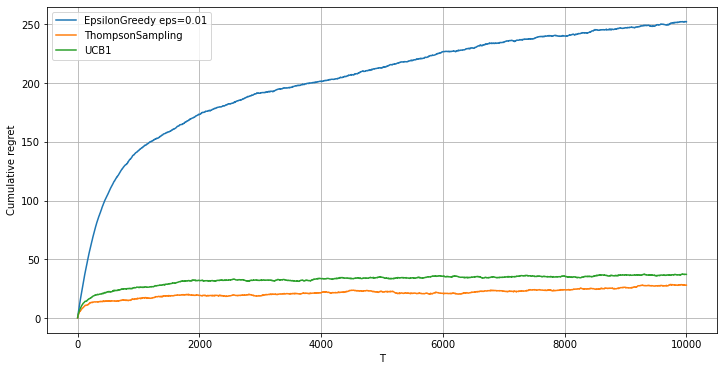

In [233]:
fig,axs=plt.subplots(figsize=(12, 6))
ts = np.arange(T)
for name, regret in agent_to_regret.items():
    sns.lineplot(x=ts, y=np.mean(regret, axis=0), label=name)
plt.xlabel('T')
plt.ylabel('Cumulative regret')
plt.grid();

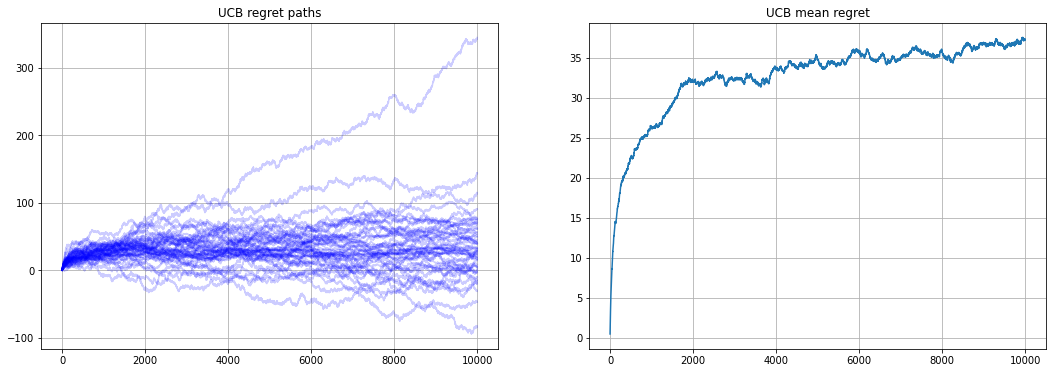

In [234]:
fig,axs=plt.subplots(figsize=(18, 6))

ts = np.arange(T)
plt.subplot(1, 2, 1)
for y in agent_to_regret['UCB1']:
    plt.plot(y, color='blue', alpha=0.2)
plt.title('UCB regret paths')
plt.grid()

plt.subplot(1, 2, 2)
sns.lineplot(x=ts, y=np.mean(agent_to_regret['UCB1'], axis=0))
plt.title('UCB mean regret')
plt.grid()